# HW 2.4

## Init properties and expected result

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage import measure

def showImg(img, colored=False):
  plt.figure(figsize=(10,10))
  plt.axis("off")
  if (len(img.shape) == 3):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  elif(colored):
    plt.imshow(img)
  else:
    plt.imshow(img, 'gray')

  plt.show()

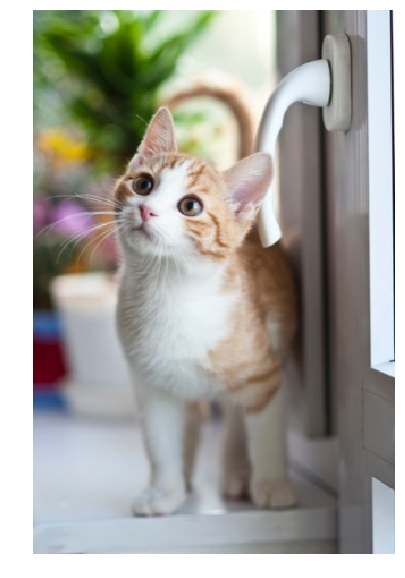

In [5]:
img = cv2.imread('./images/object/obj6.jpg')
pts1 = np.float32([
    [0,1],
    [0,2],
    [1,1]
])
pts2 = np.float32([
    [0,   1],
    [0.5, 1.5],
    [1,   1]
])
showImg(img)

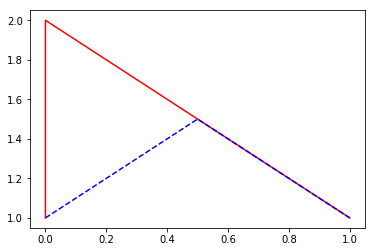

In [6]:
plt.plot(pts1[:,0], pts1[:,1], 'r-')
plt.plot(pts2[:,0], pts2[:,1], 'b--')
plt.show()

Here we can see init triandgle marked by red lines and transformed by blue.

[[0. 1.]
 [0. 2.]
 [1. 1.]]
[[0.  1. ]
 [0.5 1.5]
 [1.  1. ]]
[[ 1.   0.5 -0.5]
 [ 0.   0.5  0.5]]


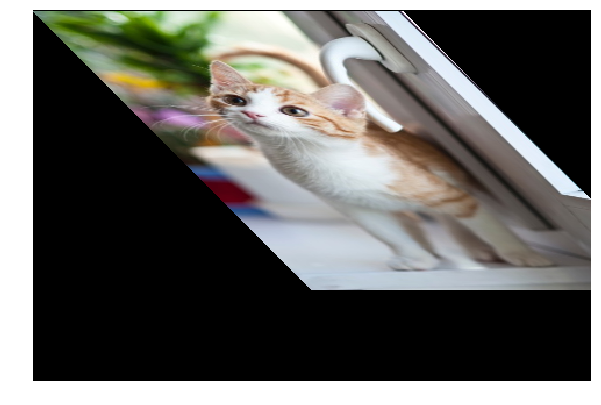

In [7]:
M = cv2.getAffineTransform(pts1,pts2)
transformedImg = cv2.warpAffine(img, M, img.shape[0:2])
print(pts1)
print(pts2)
print(M)
showImg(transformedImg)

Img after transformation

## Evaluation

$X = [\vec{x}, \vec{y}, \vec{1}]$

$y_x = \vec{y'}$

$y_y = \vec{x'}$



---


$X \times params_x = y_x$

$params_x = X^{-1} \times y_x$



---



$X \times params_y = y_y$

$params_y = X^{-1} \times y_y$

In [8]:
def getAffineTransform(p1, p2):
  X = np.c_[ p1, np.ones(len(pts1)) ]
  y_x = p2[:,0]
  y_y = p2[:,1]
  
  solution_maker = np.linalg.inv(X)

  params_x = solution_maker.dot(y_x)
  params_y = solution_maker.dot(y_y)
  
  return np.r_[[params_x], [params_y]].round(8)

[[ 1.   0.5 -0.5]
 [ 0.   0.5  0.5]]


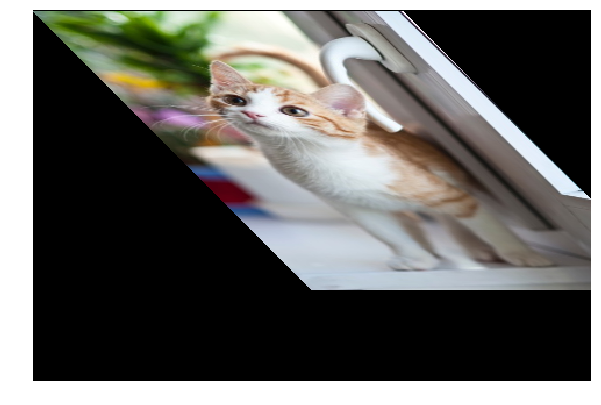

In [9]:
my_M = getAffineTransform(pts1, pts2)
transformedImg = cv2.warpAffine(img, my_M, img.shape[0:2])
print(my_M)
showImg(transformedImg)

Transformation matrix and transformed images are equal!

# HW 2.5 Projective transform

In [10]:
pts1 = np.float32([
    [0,0],
    [0,2],
    [2,2],
    [2,0],
])
pts2 = np.float32([
    [0,0],
    [0,3],
    [2.01,3],
    [2,0],
])


pts1 = np.float32([[155, 120], [480, 120], [20, 475], [620, 475]])
pts2 = np.float32([[0, 0], [500, 0], [0, 600], [500, 600]])

T = cv2.getPerspectiveTransform(pts1,pts2)
T

array([[ 2.15477997e+00,  8.19423369e-01, -4.32321700e+02],
       [ 1.83365867e-16,  4.37025797e+00, -5.24430956e+02],
       [-0.00000000e+00,  3.33839150e-03,  1.00000000e+00]])

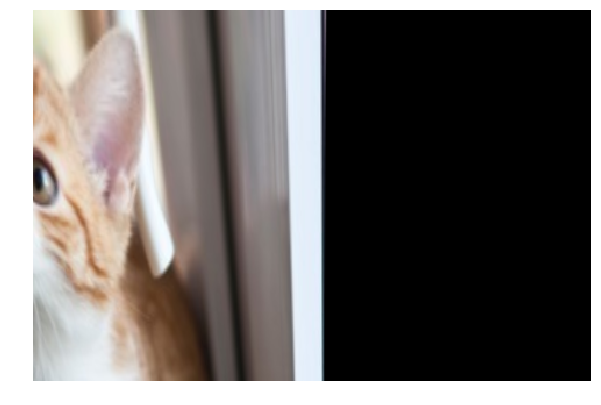

In [11]:
newImg = cv2.warpPerspective(img, T, img.shape[0:2])
showImg(newImg)

## Evaluation

$(x',y',1)^\top = T \times (x,y,1)^{T}$

$(3\times 4) = (3\times 3) \times (3 \ times 4) $

$Y = T \times X$

$Y\times X^{-1} = T$

In [12]:
# def getPerspectiveTransform(p1, p2):
#   X = np.c_[ p1, np.ones(len(p1)) ].T
#   Y = np.c_[ p2, np.ones(len(p2)) ].T
  
# #   print(np.linalg.inv(Y.T.dot(Y)))
# #   Y_ = np.linalg.inv(Y.T.dot(Y)).dot(Y.T)
# #   print(Y_)
#   T = Y.dot(np.linalg.pinv(X))
  
#   return T.round(8)

def getPerspectiveTransform(p1, p2):
    a = np.zeros((8, 8))
    b = np.zeros((8))
    for i in range(4):
        a[i][0] = a[i+4][3] = p1[i][0]
        a[i][1] = a[i+4][4] = p1[i][1]
        a[i][2] = a[i+4][5] = 1
        a[i][3] = a[i][4] = a[i][5] = 0
        a[i+4][0] = a[i+4][1] = a[i+4][2] = 0
        a[i][6] = -p1[i][0]*p2[i][0]
        a[i][7] = -p1[i][1]*p2[i][0]
        a[i+4][6] = -p1[i][0]*p2[i][1]
        a[i+4][7] = -p1[i][1]*p2[i][1]
        b[i] = p2[i][0]
        b[i+4] = p2[i][1]

    x = np.linalg.solve(a, b)
    x.resize((9,), refcheck=False)
    x[8] = 1 # Set c22 to 1 as indicated in comment above
    return x.reshape((3,3))
  
my_T = getPerspectiveTransform(pts1, pts2)
my_T

array([[ 2.15477997e+00,  8.19423369e-01, -4.32321700e+02],
       [-6.81891819e-16,  4.37025797e+00, -5.24430956e+02],
       [-1.15866430e-18,  3.33839150e-03,  1.00000000e+00]])

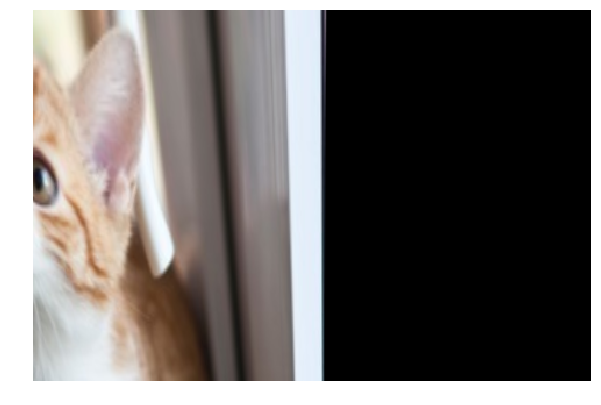

In [13]:
newImg = cv2.warpPerspective(img, my_T, img.shape[0:2])
showImg(newImg)

Transformation matrix and transformed images are equal!

# HW 2.6 Patch match

In [14]:
pts1 = np.float32([[155, 120], [480, 120], [20, 475], [620, 475]])
pts2 = np.float32([[0, 0], [500, 0], [0, 600], [500, 600]])

getPerspectiveTransform(pts1,pts2)

array([[ 2.15477997e+00,  8.19423369e-01, -4.32321700e+02],
       [-6.81891819e-16,  4.37025797e+00, -5.24430956e+02],
       [-1.15866430e-18,  3.33839150e-03,  1.00000000e+00]])

In [15]:
pts1 = np.float32([[155, 120], [480, 120], [20, 475], [620, 475]])
pts2 = np.float32([[0, 0], [500, 0], [0, 600], [500, 600]])

cv2.getPerspectiveTransform(pts1,pts2)

array([[ 2.15477997e+00,  8.19423369e-01, -4.32321700e+02],
       [ 1.83365867e-16,  4.37025797e+00, -5.24430956e+02],
       [-0.00000000e+00,  3.33839150e-03,  1.00000000e+00]])

In [16]:
import numpy as np
import cv2


class PatchMatch(object):
    def __init__(self, a, aa, b, bb, patch_size):
        """
        Initialize Patchmatch Object.
        This method also randomizes the nnf , which will eventually
        be optimized.
        """
        assert a.shape == b.shape == aa.shape == bb.shape, "Dimensions were unequal for patch-matching input"
        self.A = a
        self.B = b
        self.AA = aa
        self.BB = bb
        self.patch_size = patch_size
        self.nnf = np.zeros(shape=(2, self.A.shape[0], self.A.shape[1])).astype(np.int)  # the nearest neighbour field
        self.nnd = np.zeros(shape=(self.A.shape[0], self.A.shape[1]))  # the distance map for the nnf
        self.initialise_nnf()

    def initialise_nnf(self):
        """
        Set up a random NNF
        Then calculate the distances to fill up the NND
        :return:
        """
        self.nnf[0] = np.random.randint(self.B.shape[1], size=(self.A.shape[0], self.A.shape[1]))
        self.nnf[1] = np.random.randint(self.B.shape[0], size=(self.A.shape[0], self.A.shape[1]))
        self.nnf = self.nnf.transpose((1, 2, 0))
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                pos = self.nnf[i, j]
                self.nnd[i, j] = self.cal_dist(i, j, pos[1], pos[0])

    def cal_dist(self, ay, ax, by, bx):
        """
        Calculate distance between a patch in A to a patch in B.
        :return: Distance calculated between the two patches
        """
        dx0 = dy0 = self.patch_size // 2
        dx1 = dy1 = self.patch_size // 2 + 1
        dx0 = min(ax, bx, dx0)
        dx1 = min(self.A.shape[0] - ax, self.B.shape[0] - bx, dx1)
        dy0 = min(ay, by, dy0)
        dy1 = min(self.A.shape[1] - ay, self.B.shape[1] - by, dy1)
        return np.sum(((self.A[ay - dy0:ay + dy1, ax - dx0:ax + dx1] - self.B[by - dy0:by + dy1, bx - dx0:bx + dx1]) ** 2) + (
            (self.AA[ay - dy0:ay + dy1, ax - dx0:ax + dx1] - self.BB[by - dy0:by + dy1, bx - dx0:bx + dx1]) ** 2)) / ((dx1 + dx0) * (dy1 + dy0))

    def reconstruct_image(self, img_a):
        """
        Reconstruct image using the NNF and img_a.
        :param img_a: the patches to reconstruct from
        :return: reconstructed image
        """
        final_img = np.zeros_like(img_a)
        size = self.nnf.shape[0]
        scale = img_a.shape[0] // self.nnf.shape[0]
        for i in range(size):
            for j in range(size):
                x, y = self.nnf[i, j]
                if final_img[scale * i:scale * (i + 1), scale * j:scale * (j + 1)].shape == img_a[scale * y:scale * (y + 1), scale * x:scale * (x + 1)].shape:
                    final_img[scale * i:scale * (i + 1), scale * j:scale * (j + 1)] = img_a[scale * y:scale * (y + 1), scale * x:scale * (x + 1)]
        return final_img

    def reconstruct_avg(self, img, patch_size=5):
        """
        Reconstruct image using average voting.
        :param img: the image to reconstruct from. Numpy array of dim H*W*3
        :param patch_size: the patch size to use
        :return: reconstructed image
        """

        final = np.zeros_like(img)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):

                dx0 = dy0 = patch_size // 2
                dx1 = dy1 = patch_size // 2 + 1
                dx0 = min(j, dx0)
                dx1 = min(img.shape[0] - j, dx1)
                dy0 = min(i, dy0)
                dy1 = min(img.shape[1] - i, dy1)

                patch = self.nnf[i - dy0:i + dy1, j - dx0:j + dx1]

                lookups = np.zeros(shape=(patch.shape[0], patch.shape[1], img.shape[2]), dtype=np.float32)

                for ay in range(patch.shape[0]):
                    for ax in range(patch.shape[1]):
                        x, y = patch[ay, ax]
                        lookups[ay, ax] = img[y, x]

                if lookups.size > 0:
                    value = np.mean(lookups, axis=(0, 1))
                    final[i, j] = value

        return final

    def upsample_nnf(self, size):
        """
        Upsample NNF based on size. It uses nearest neighbour interpolation
        :param size: INT size to upsample to.
        :return: upsampled NNF
        """

        temp = np.zeros((self.nnf.shape[0], self.nnf.shape[1], 3))

        for y in range(self.nnf.shape[0]):
            for x in range(self.nnf.shape[1]):
                temp[y][x] = [self.nnf[y][x][0], self.nnf[y][x][1], 0]

        img = np.zeros(shape=(size, size, 2), dtype=np.int)
        small_size = self.nnf.shape[0]
        aw_ratio = ((size) // small_size)
        ah_ratio = ((size) // small_size)

        temp = cv2.resize(temp, None, fx=aw_ratio, fy=aw_ratio, interpolation=cv2.INTER_NEAREST)

        for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
                pos = temp[i, j]
                img[i, j] = pos[0] * aw_ratio, pos[1] * ah_ratio

        return img

    def visualize(self):
        """
        Get the NNF visualisation
        :return: The RGB Matrix of the NNF
        """
        nnf = self.nnf

        img = np.zeros((nnf.shape[0], nnf.shape[1], 3), dtype=np.uint8)

        for i in range(nnf.shape[0]):
            for j in range(nnf.shape[1]):
                pos = nnf[i, j]
                img[i, j, 0] = int(255 * (pos[0] / self.B.shape[1]))
                img[i, j, 2] = int(255 * (pos[1] / self.B.shape[0]))

        return img

    def propagate(self, iters=2, rand_search_radius=200,queue=None):
        """
        Optimize the NNF using PatchMatch Algorithm
        :param iters: number of iterations
        :param rand_search_radius: max radius to use in random search
        :return:
        """
        a_cols = self.A.shape[1]
        a_rows = self.A.shape[0]

        b_cols = self.B.shape[1]
        b_rows = self.B.shape[0]

        for it in range(iters):
            ystart = 0
            yend = a_rows
            ychange = 1
            xstart = 0
            xend = a_cols
            xchange = 1

            if it % 2 == 1:
                xstart = xend - 1
                xend = -1
                xchange = -1
                ystart = yend - 1
                yend = -1
                ychange = -1

            ay = ystart
            while ay != yend:

                ax = xstart
                while ax != xend:

                    xbest, ybest = self.nnf[ay, ax]
                    dbest = self.nnd[ay, ax]
                    if ax - xchange < a_cols and ax - xchange >= 0:
                        vp = self.nnf[ay, ax - xchange]
                        xp = vp[0] + xchange
                        yp = vp[1]
                        if xp < b_cols and xp >= 0:
                            val = self.cal_dist(ay, ax, yp, xp)
                            if val < dbest:
                                xbest, ybest, dbest = xp, yp, val

                    if abs(ay - ychange) < a_rows and ay - ychange >= 0:
                        vp = self.nnf[ay - ychange, ax]
                        xp = vp[0]
                        yp = vp[1] + ychange
                        if yp < b_rows and yp >= 0:
                            val = self.cal_dist(ay, ax, yp, xp)
                            if val < dbest:
                                xbest, ybest, dbest = xp, yp, val
                    if rand_search_radius is None:
                        rand_d = max(self.B.shape[0], self.B.shape[1])
                    else:
                        rand_d = rand_search_radius

                    while rand_d >= 1:
                        try:
                            xmin = max(xbest - rand_d, 0)
                            xmax = min(xbest + rand_d, b_cols)

                            ymin = max(ybest - rand_d, 0)
                            ymax = min(ybest + rand_d, b_rows)

                            if xmin > xmax:
                                rx = -np.random.randint(xmax, xmin)
                            if ymin > ymax:
                                ry = -np.random.randint(ymax, ymin)

                            if xmin <= xmax:
                                rx = np.random.randint(xmin, xmax)
                            if ymin <= ymax:
                                ry = np.random.randint(ymin, ymax)

                            val = self.cal_dist(ay, ax, ry, rx)
                            if val < dbest:
                                xbest, ybest, dbest = rx, ry, val

                        except Exception as e:
                            print(e)
                            print(rand_d)
                            print(xmin, xmax)
                            print(ymin, ymax)
                            print(xbest, ybest)
                            print(self.B.shape)

                        rand_d = rand_d // 2

                    self.nnf[ay, ax] = [xbest, ybest]
                    self.nnd[ay, ax] = dbest

                    ax += xchange
                ay += ychange
            print("Done iteration {}".format(it + 1))
        print("Done All Iterations")
        if queue:
            queue.put(self.nnf)

In [ ]:

x = cv2.imread("./a1.jpg")
y = cv2.imread("./a2.jpg")

x = cv2.resize(x,(224,224))
y = cv2.resize(y,(224,224))


x = (x/255).astype(np.float32)
y = (y/255).astype(np.float32)

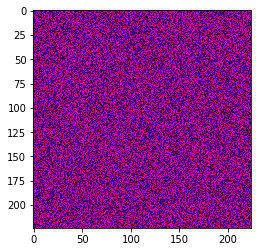

In [ ]:
pm = PatchMatch(x,x,y,y, 3)
plt.imshow(pm.visualize())

In [ ]:
pm.propagate(iters=10,rand_search_radius=224)


Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done iteration 6
Done iteration 7
Done iteration 8
Done iteration 9
Done iteration 10
Done All Iterations


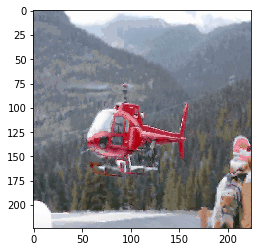

In [ ]:
plt.imshow(pm.reconstruct_avg(img=y,patch_size=1)[:,:,::-1])

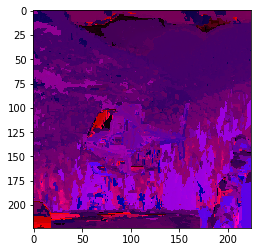

In [ ]:
plt.imshow(pm.visualize())
